# Simple usage

This notebook demonstrates basic usage of the *fastTSNE* library. This is sufficient for almost all use-cases.

In [1]:
from fastTSNE import TSNE
from fastTSNE.callbacks import ErrorLogger  # So we can print out errors during optimization

from examples import utils  # Utils for loading data and plotting embeddings

import numpy as np
import scipy.sparse as sp

import matplotlib.pyplot as plt

### Load data

In this notebook, we'll be using the Zeisel 2018 mouse nervous system data set. Most often, the MNIST digit data set is used to benchmark t-SNE, however this data set is even larger. It contains around 160k samples, which is more than twice the size of MNIST (70k samples). This was done purely to demonstrate the speed of the library.

The data set can be obtained through [Linnarsson Lab](https://storage.googleapis.com/linnarsson-lab-loom/l5_all.loom), but it is 18GB, so download at your own peril.

In [2]:
x, y = utils.get_zeisel_2018()

# x and y have the following data types
x: sp.spmatrix
y: np.ndarray

In [3]:
print('Data set contains %d samples with %d features' % x.shape)

Data set contains 160796 samples with 27932 features


### SVD preprocessing

When our data are noisy, we typically first run PCA and then run t-SNE on the reduced data representation. This aleviates the crowding problem since t-SNE doesn't scale well with ambient dimension as well as substantially speeding things up.

However, given that the data set we're dealing with are fairly large, we can't form the dense covariance matrix needed for PCA, so we opt for SVD. Like PCA, SVD finds a linear basis, and seems to work well enough for most single-cell data.

In [4]:
print('Sparsity: %.2f%%' % (100 * x.nnz / np.prod(x.shape)))

Sparsity: 5.63%


In [5]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=50)

In [6]:
%time x_prime = svd.fit_transform(x)

CPU times: user 2min 53s, sys: 8.87 s, total: 3min 2s
Wall time: 2min 50s


In [7]:
print('X\' contains %d samples and %d principal components' % x_prime.shape)

X' contains 160796 samples and 50 principal components


Note that $X'$ is now a dense matrix. Currently, our t-SNE implementation only handles dense matrices - if we skipped the PCA preprocessing step, we would have to densify our $X$ matrix.

### t-SNE

We can now run t-SNE on our principal components. We'll use the fast parameter settings `negative_gradient_method='fft'` to use the interpolation based gradient approximation and `neighbors='approx'` to compute approximate nearest neighbors instead of exact neighbors.

In [8]:
tsne = TSNE(n_components=2, negative_gradient_method='fft', neighbors='approx',
            callbacks=ErrorLogger(), n_jobs=8)

In [9]:
%time embedding = tsne.fit(x_prime)

Iteration   50, KL divergence  8.3611, 50 iterations in 4.1316 sec
Iteration  100, KL divergence  7.8452, 50 iterations in 4.0820 sec
Iteration  150, KL divergence  7.0355, 50 iterations in 4.1538 sec
Iteration  200, KL divergence  6.5174, 50 iterations in 4.0147 sec
Iteration  250, KL divergence  6.1836, 50 iterations in 4.1114 sec
Iteration   50, KL divergence  6.0538, 50 iterations in 4.1584 sec
Iteration  100, KL divergence  5.7985, 50 iterations in 4.1637 sec
Iteration  150, KL divergence  5.5156, 50 iterations in 4.4439 sec
Iteration  200, KL divergence  5.2497, 50 iterations in 4.4803 sec
Iteration  250, KL divergence  5.0140, 50 iterations in 4.3713 sec
Iteration  300, KL divergence  4.8083, 50 iterations in 4.4859 sec
Iteration  350, KL divergence  4.6296, 50 iterations in 4.6542 sec
Iteration  400, KL divergence  4.4736, 50 iterations in 5.1755 sec
Iteration  450, KL divergence  4.3362, 50 iterations in 4.9767 sec
Iteration  500, KL divergence  4.2146, 50 iterations in 5.3899

In [10]:
print('Our embedding contains %d samples and %d t-SNE components' % embedding.shape)

Our embedding contains 160796 samples and 2 t-SNE components


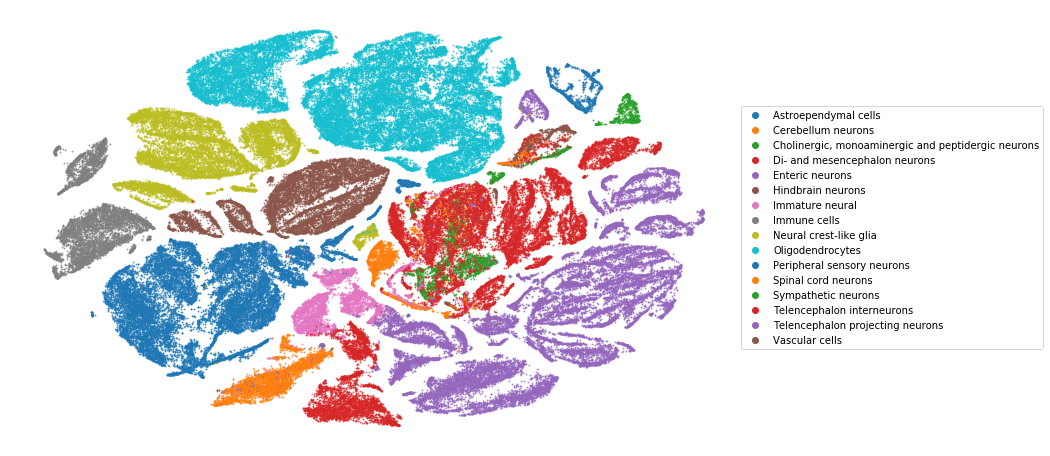

In [11]:
fig = plt.figure(figsize=(13, 8))
utils.plot(embedding, y, ax=fig.gca())